In [4]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv

In [58]:
sixteen = generate_random_map(16)
tweenty = generate_random_map(20)
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],

    "16x16": sixteen,
    "20x20": tweenty,
  #  "20x20": ["SFFFFFFFFFFFFFFFHFFH",
  #            "FFFFFFFFHFFFFFFFHFFH",
  #            "FFFHFFFFFFHFFFFFHFFH",
  #            "FFFFFFFFHFFFFHFFHFFH",
  #            "FFFHFFHHFFFHFFFFHFFH",
  #            "FHHFFFHFFHFHFFHFHFFH",
  #            "FHFFHFHFFHFHFFHFHFFH",
  #            "FFFFFFFFFHFHFFHFHFFH",
  #            "FFFFFFFFFHFHFFHFHFFH",
  #            "FFFHFFFFFHFHFFHFHFFH",
  #            "FFFFFHFFFHFHFFHFHFFH",
  #            "FFFHFFFFFHFHFFHFHFFH",
  #            "FHHFFFHFFHFHFFHFHFFH",
  #            "FHFFHFHFFFFFHFFHFFFF",
  #            "SFFFFFFFFFHFHFFHFFFF",
  #            "FFFFFFFFFFFFHFFHHFFF",
  #            "FFFHFFFFFFHFHFFHFFFF",
  #            "FFFFFHFFHHFFHFFHFHFF",
  #            "FFFHFFFFHFFHHFFHFHFF",
  #            "FFFHFFFFFFFHFFHHFFFG"   
   # ]
}

env = FrozenLakeEnv(desc=MAPS["20x20"])
env.render()



SFFHFFFHFHFFHFFHFFFF
FFFFFFFFFFFFFHHHFFFF
FFHFHHHFFFFFFFHFFFFF
HFFFFFFFHFFFFFFFFFFH
FFFFFFFFFHFFFFFFFFHF
FFFFHFFFFHFFFFHFFHHF
FFFFFFFFFFFFFFFFFFHF
FFFFFFFFFFHFHFFFFFHF
FFFFFHHFFFFFFFFHFFFH
FFFFFFFFHFFFHFFFFFFH
HFFFFFFFHHHFFFFFFFHF
FFFFHHFFHFFFFFFHFFFF
FFFFHFHFHFFFFFFFFFFF
FFHHFFFFFFFHFFFFFFHF
FFFFHHFHFFHFFFFHFFFF
FHFHFHFFFFFHHFFFHFFF
FFHFFFFHHFFHHFFFFFFF
FHFHFFFFHFFFFFFFFFFF
HFFFFFFFFHFFFFFHHFFF
FFFFFFFFHFFHFFFFFHHG


In [12]:
# Method 1 : Value Iteration
def vi(env, disc=0.99, eps = 1e-5):
    t0 = time.time()
    iterations = 0
    num_spaces = env.observation_space.n
    num_actions = env.action_space.n
    policy = np.zeros((num_spaces, 1))
    change = 1
    val_list = np.zeros((num_spaces, 1))
    old_list = val_list.copy()
    while change>eps:
        iterations = iterations+1
        for space in range(num_spaces):
            current_val = -np.inf
            for action in range(num_actions):
                total_val = 0
                for prob, new_state, reward, complete in env.P[space][action]:
                #    print (space, action, ' ~~~ ' , prob, new_state, reward, complete)
                    if (complete == True and reward!=1):
                        reward = -0.75 #penalty for holes
                    val = 0
                    new_val = old_list[new_state][0]
                    if (complete):
                        val = reward
                    else:
                        val = reward + disc*new_val
                    total_val = total_val + val*prob
                    
                if (total_val > current_val):
                    current_val = total_val
                    policy[space][0] = action
                    val_list[space][0] = current_val
                    
        changes = np.abs(val_list - old_list)
        change = np.max(changes)
        old_list = val_list.copy()
                    
    runtime = time.time() - t0
    return iterations, policy, runtime

# Method 2 : Policy Iteration
def compute_policy_v(env, policy, gamma, eps):
    v = np.zeros(env.nS)
#    eps = 1e-5
    while True:
        prev_v = np.copy(v)
        for s in range(env.nS):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, is_done in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            break
    return v

def extract_policy(env,v, gamma):
    policy = np.zeros(env.nS)
    for s in range(env.nS):
        q_sa = np.zeros(env.nA)
        for a in range(env.nA):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in  env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy

def pi2 (env, disc=0.99, eps = 1e-5):
    t0 = time.time()
    policy = np.random.choice(env.nA, size=(env.nS))  
    max_iters = 2000
    k = 0
    for i in range(max_iters):
        old_policy_v = compute_policy_v(env, policy, disc, eps)
        new_policy = extract_policy(env,old_policy_v, eps)
        if (np.all(policy == new_policy)):
            k=i+1
            break
        policy = new_policy
    pi_time_val = time.time() - t0
    return k, policy, pi_time_val



# Method 3 : QL
def ql(env, alpha=0.9, gamma=0.99, eps=0.9, episodes = 100):
    t0 = time.time()
    num_spaces = env.observation_space.n
    num_actions = env.action_space.n
    
    Q = np.zeros((num_spaces, num_actions))
    rewards = []
    iters = []
    best_policy = [0]*num_spaces
    
    for episode in range(episodes):
        #print ('\n', episode)
        state = env.reset()
        done = False
        max_steps = 1000
        total_reward = 0
        for i in range(max_steps):
            if done:
                break
            
            current = state
            if (np.random.rand() < eps):
                action = np.argmax(Q[current, :])
            else:
                action = env.action_space.sample()
                    
            state, reward, done, info = env.step(action)
            if (done == True and reward!=1):
                reward = -0.75 #penalty for holes
            total_reward = total_reward+reward
            Q[current, action] = (1-alpha)*Q[current, action] + alpha * (reward + gamma * np.max(Q[state, :]))
        rewards.append(total_reward)
        #print (i)
        iters.append(i)
    
        for j in range(num_spaces):
            best_policy[j] = np.argmax(Q[j, :])
    
    q_solve_iter = np.mean(iters)
    avg_reward = np.mean(rewards)
    ql_time_val = time.time() - t0
    return best_policy, q_solve_iter, ql_time_val, Q, avg_reward

In [83]:
def get_rewards_iters(env, policy, epochs = 100):
    rewards = []
    iters = []
    
    for i in range(epochs):
        state = env.reset()
        n_iters = 0
        done = False
        each_epoch_reward = 0
        completed = False
        while not completed and n_iters<100000:
            n_iters = n_iters + 1
            action = int(policy[state])
            new_state, reward, done, _ = env.step(action)
            each_epoch_reward = each_epoch_reward + reward
            state = new_state
            if (done == True and reward == 1):
                completed = True
            
        rewards.append(each_epoch_reward)
        iters.append(n_iters)
    
    avg_rewards = np.mean(rewards)
    avg_iters = np.mean(iters)
    
    return avg_rewards, avg_iters

In [59]:
disc_rate = [0.5, 0.7, 0.9, 0.99, 0.999]
eps = [1e-15, 1e-13, 1e-11,1e-9, 1e-7,1e-5, 1e-3, 1e-1, 0.2]
vi_iter = np.zeros((len(disc_rate), len(eps)))
vi_policy =  {}
vi_time = np.zeros((len(disc_rate), len(eps)))
vi_reward = np.zeros((len(disc_rate), len(eps)))
vi_episode = np.zeros((len(disc_rate), len(eps)))

pi_iter = np.zeros((len(disc_rate), len(eps)))
pi_policy = {}
pi_time = np.zeros((len(disc_rate), len(eps)))
pi_reward = np.zeros((len(disc_rate), len(eps)))
pi_episode = np.zeros((len(disc_rate), len(eps)))

ql_iter = np.zeros((len(disc_rate), len(eps)))
ql_policy = {}
ql_time = np.zeros((len(disc_rate), len(eps)))
ql_reward = np.zeros((len(disc_rate), len(eps)))
ql_episode = np.zeros((len(disc_rate), len(eps)))
ql_qarray = np.zeros((len(disc_rate), len(eps)))
ql_rewards = np.zeros((len(disc_rate), len(eps)))


for i in range(len(disc_rate)):
#for i in range(1):
    #print ('\n i ', i)
    vi_policy[i]={}
    pi_policy[i]={}
    for j in range(len(eps)):
    #for j in range(1):
        print ('   j ', j)
        vi_policy[i][j] = {}
        vi_iter_val, vi_policy_val, vi_time_val = vi(env, disc_rate[i], eps[j])
        #print ('  VI => ', vi_iter_val, vi_time_val)
        #print (vi_policy_val)
        vi_reward_val, vi_episode_val = get_rewards_iters(env, vi_policy_val, epochs = 100)
        print (vi_reward_val, vi_episode_val)
        vi_iter[i][j]    = vi_iter_val
        vi_policy[i][j]  = vi_policy_val
        vi_time[i][j]    = vi_time_val
        vi_reward[i][j]  = vi_reward_val
        vi_episode[i][j] = vi_episode_val
        
        pi_policy[i][j] = {}
        
        #print ('PI2 --- ')
        pi_iter_val, pi_policy_val, pi_time_val = pi2(env, disc_rate[i], eps[j])
        pi_reward_val, pi_episode_val = get_rewards_iters(env, pi_policy_val, epochs = 100)
        #print (policy)
        #print (pi_reward_val, pi_episode_val)
        pi_iter[i][j]    = pi_iter_val
        pi_policy[i][j]  = pi_policy_val
        pi_time[i][j]    = pi_time_val
        pi_reward[i][j]  = pi_reward_val
        pi_episode[i][j] = pi_episode_val
        

   j  0
0.0 1000.0
   j  1
0.03 994.88
   j  2
0.02 991.53
   j  3
0.03 988.16
   j  4
0.04 990.89
   j  5
0.07 985.39
   j  6
0.0 1000.0
   j  7
0.0 1000.0
   j  8
0.0 1000.0
   j  0
0.03 991.95
   j  1
0.0 1000.0
   j  2
0.02 993.49
   j  3
0.03 986.55
   j  4
0.04 985.3
   j  5
0.02 995.19
   j  6
0.03 980.25
   j  7
0.0 1000.0
   j  8
0.0 1000.0
   j  0
0.1 973.35
   j  1
0.07 977.76
   j  2
0.12 964.84
   j  3
0.08 972.4
   j  4
0.11 959.7
   j  5
0.07 982.92
   j  6
0.03 988.99
   j  7
0.0 1000.0
   j  8
0.0 1000.0
   j  0
0.84 477.08
   j  1
0.87 490.97
   j  2
0.89 484.01
   j  3
0.82 510.81
   j  4
0.86 496.62
   j  5
0.88 496.72
   j  6
0.23 905.55
   j  7
0.0 1000.0
   j  8
0.0 1000.0
   j  0
0.79 516.42
   j  1
0.88 479.97
   j  2
0.88 491.95
   j  3
0.83 552.03
   j  4
0.86 541.83
   j  5
0.89 493.93
   j  6
0.87 496.14
   j  7
0.0 1000.0
   j  8
0.0 1000.0


In [15]:
print (disc_rate)
print (eps)
print (vi_iter)

print (type(vi_iter))
print ((vi_iter.shape))



print ('\n', vi_reward)
print ('\n', vi_episode)

[0.5, 0.7, 0.9, 0.99, 0.999]
[1e-15, 1e-13, 1e-11, 1e-09, 1e-07, 1e-05, 0.001, 0.1, 0.2]
[[4.400e+01 3.700e+01 3.100e+01 2.500e+01 1.800e+01 1.200e+01 7.000e+00
  2.000e+00 2.000e+00]
 [8.200e+01 6.900e+01 5.700e+01 4.500e+01 3.300e+01 2.100e+01 1.000e+01
  3.000e+00 2.000e+00]
 [2.720e+02 2.290e+02 1.860e+02 1.430e+02 1.010e+02 6.000e+01 2.400e+01
  3.000e+00 2.000e+00]
 [1.943e+03 1.652e+03 1.360e+03 1.065e+03 7.660e+02 4.510e+02 1.320e+02
  3.000e+00 2.000e+00]
 [4.875e+03 4.140e+03 3.403e+03 2.666e+03 1.927e+03 1.178e+03 3.410e+02
  3.000e+00 2.000e+00]]
<class 'numpy.ndarray'>
(5, 9)

 [[0.   0.04 0.03 0.02 0.   0.   0.   0.   0.  ]
 [0.1  0.07 0.12 0.08 0.06 0.07 0.03 0.   0.  ]
 [1.   0.85 0.95 0.89 0.95 0.89 0.07 0.   0.  ]
 [0.88 0.91 0.9  0.94 0.9  0.94 0.95 0.   0.  ]
 [0.96 0.98 0.96 0.97 0.98 0.98 0.93 0.   0.  ]]

 [[1000.    984.03  985.51  994.22 1000.   1000.   1000.   1000.   1000.  ]
 [ 975.21  972.61  952.01  957.78  970.85  987.24  995.1  1000.   1000.  ]
 [ 312.12

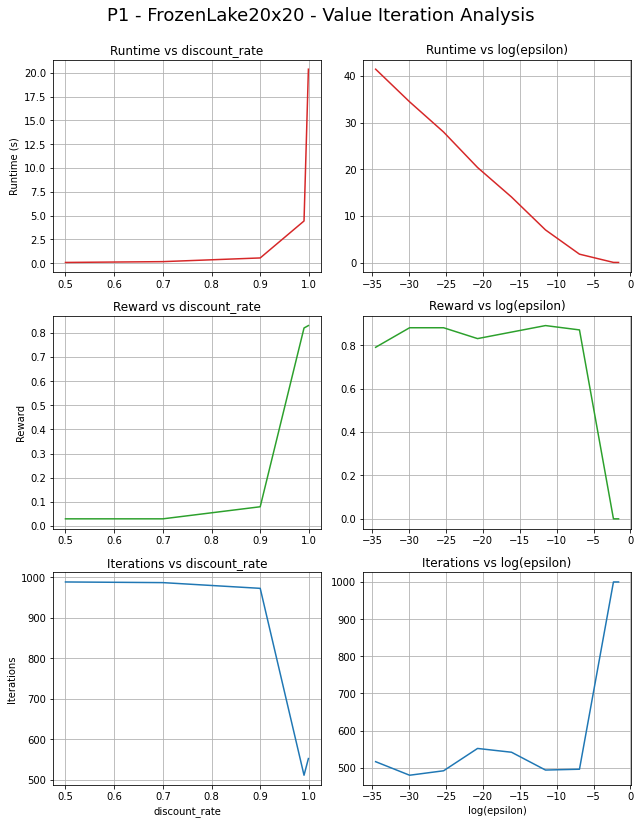

In [74]:
disc_rate = [0.5, 0.7, 0.9, 0.99, 0.999]
eps = [1e-15, 1e-13, 1e-11,1e-9, 1e-7,1e-5, 1e-3, 1e-1, 0.2]
fig, axs = plt.subplots(3,2, figsize=(9,12))
axs[0, 0].plot(disc_rate, vi_time[:,3], 'tab:red')
axs[0, 0].set_title('Runtime vs discount_rate')
axs[0, 0].set(ylabel='Runtime (s)')
axs[0, 0].grid()
axs[0, 1].plot(np.log(eps), vi_time[4,:], 'tab:red')
axs[0, 1].set_title('Runtime vs log(epsilon)')
axs[0, 1].grid()

axs[1, 0].plot(disc_rate, vi_reward[:,3], 'tab:green')
axs[1, 0].set_title('Reward vs discount_rate')
axs[1, 0].set(ylabel='Reward')
axs[1, 0].grid()
axs[1, 1].plot(np.log(eps), vi_reward[4,:], 'tab:green')
axs[1, 1].set_title('Reward vs log(epsilon)')
axs[1, 1].grid()

axs[2, 0].plot(disc_rate, vi_episode[:,3], 'tab:blue')
axs[2, 0].set_title('Iterations vs discount_rate')
axs[2, 0].set(xlabel='discount_rate')
axs[2, 0].set(ylabel='Iterations')
axs[2, 0].grid()
axs[2, 1].plot(np.log(eps), vi_episode[4,:], 'tab:blue')
axs[2, 1].set_title('Iterations vs log(epsilon)')
axs[2, 1].set(xlabel='log(epsilon)')
axs[2, 1].grid()



fig.suptitle('P1 - FrozenLake20x20 - Value Iteration Analysis', fontsize=18)

#plt.legend()
#plt.ylim(0, 5e-6)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [22]:
print (disc_rate)
print (eps)
print (pi_iter)

print (type(pi_iter))
print ((pi_iter.shape))



print ('\n', pi_reward)
print ('\n', pi_episode)

[0.5, 0.7, 0.9, 0.99, 0.999]
[1e-15, 1e-13, 1e-11, 1e-09, 1e-07, 1e-05, 0.001, 0.1, 0.2]
[[18.  6.  5.  5.  8.  7.  6.  4.  3.]
 [ 7.  7.  6. 17.  8. 16.  9.  4.  3.]
 [ 5.  7. 17.  7. 16. 18. 17.  8.  5.]
 [ 8.  8.  6. 17. 17. 17.  9. 18.  0.]
 [19.  8. 19.  8.  9.  6. 19. 16.  0.]]
<class 'numpy.ndarray'>
(5, 9)

 [[0.33 0.23 0.18 0.28 0.   0.   0.   0.   0.  ]
 [0.17 0.25 0.28 0.23 0.23 0.25 0.   0.   0.  ]
 [0.34 0.36 0.36 0.29 0.31 0.35 0.38 0.   0.  ]
 [0.62 0.71 0.73 0.69 0.81 0.81 0.81 0.59 0.  ]
 [0.92 0.92 0.96 0.94 0.91 0.94 0.91 0.95 0.  ]]

 [[ 714.92  800.15  843.68  750.16 1000.   1000.   1000.   1000.   1000.  ]
 [ 852.64  780.92  753.34  801.26  801.16  779.21 1000.   1000.   1000.  ]
 [ 704.42  686.7   688.7   751.57  733.51  700.69  671.93 1000.   1000.  ]
 [ 491.45  435.94  426.08  447.57  352.82  351.95  341.2   525.15 1000.  ]
 [ 316.37  327.01  289.26  268.84  323.16  327.74  330.67  325.41 1000.  ]]


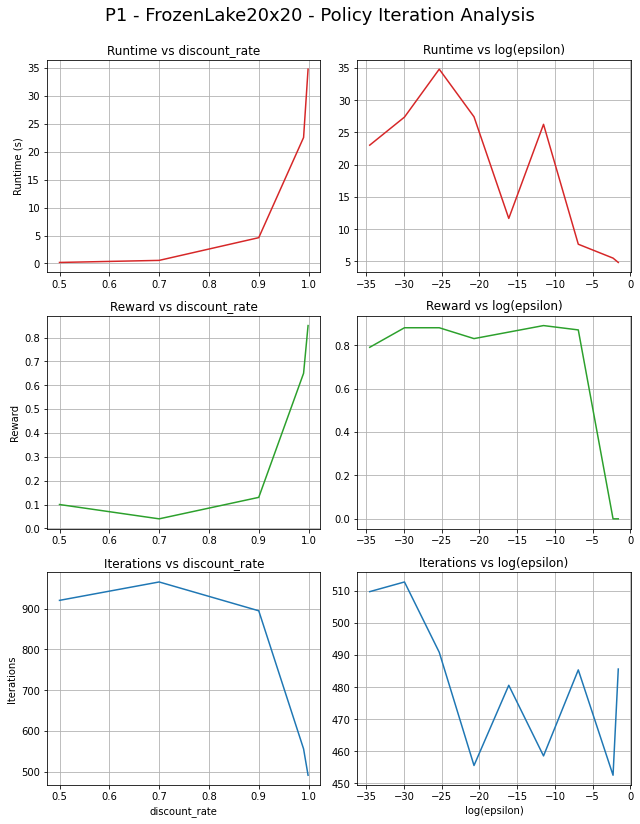

In [75]:
disc_rate = [0.5, 0.7, 0.9, 0.99, 0.999]
eps = [1e-15, 1e-13, 1e-11,1e-9, 1e-7,1e-5, 1e-3, 1e-1, 0.2]
fig, axs = plt.subplots(3,2, figsize=(9,12))
axs[0, 0].plot(disc_rate, pi_time[:,2], 'tab:red')
axs[0, 0].set_title('Runtime vs discount_rate')
axs[0, 0].set(ylabel='Runtime (s)')
axs[0, 0].grid()
axs[0, 1].plot(np.log(eps), pi_time[4,:], 'tab:red')
axs[0, 1].set_title('Runtime vs log(epsilon)')
axs[0, 1].grid()

axs[1, 0].plot(disc_rate, pi_reward[:,2], 'tab:green')
axs[1, 0].set_title('Reward vs discount_rate')
axs[1, 0].set(ylabel='Reward')
axs[1, 0].grid()
axs[1, 1].plot(np.log(eps), vi_reward[4,:], 'tab:green')
axs[1, 1].set_title('Reward vs log(epsilon)')
axs[1, 1].grid()

axs[2, 0].plot(disc_rate, pi_episode[:,2], 'tab:blue')
axs[2, 0].set_title('Iterations vs discount_rate')
axs[2, 0].set(xlabel='discount_rate')
axs[2, 0].set(ylabel='Iterations')
axs[2, 0].grid()
axs[2, 1].plot(np.log(eps), pi_episode[4,:], 'tab:blue')
axs[2, 1].set_title('Iterations vs log(epsilon)')
axs[2, 1].set(xlabel='log(epsilon)')
axs[2, 1].grid()



fig.suptitle('P1 - FrozenLake20x20 - Policy Iteration Analysis', fontsize=18)

#plt.legend()
#plt.ylim(0, 5e-6)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [84]:
disc_rate = [0.5, 0.7, 0.9, 0.99, 0.999]
eps = [1e-15, 1e-13, 1e-11,1e-9, 1e-7,1e-5, 1e-3, 1e-1, 0.2]
alpha = [0.5, 0.7, 0.9, 0.99]
gamma = [0.8, 0.9, 0.99, 0.999 ]
eps = [0.5, 0.7, 0.9, 0.99]
episode = [10, 50, 100, 500, 1000]


ql_iter = np.zeros((len(disc_rate), len(eps)))
ql_policy = {}
ql_time = np.zeros((len(disc_rate), len(eps)))
ql_reward = np.zeros((len(disc_rate), len(eps)))
ql_episode = np.zeros((len(disc_rate), len(eps)))
ql_qarray = np.zeros((len(disc_rate), len(eps)))
ql_rewards = np.zeros((len(disc_rate), len(eps)))

alpha_var = np.zeros((len(alpha), 3))
gamma_var = np.zeros((len(gamma), 3))
epsilon_var = np.zeros((len(eps), 3))
episode_var = np.zeros((len(episode), 3))

print ('1')
for i in range(len(alpha)):
    best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env, alpha=alpha[i], gamma=0.99, eps=0.9, episodes = 100)
    vi_reward_val, vi_episode_val = get_rewards_iters(env, best_policy, epochs = 100)
    alpha_var[i,0] = ql_time_val
    alpha_var[i,1] = avg_reward
    alpha_var[i,2] = vi_episode_val
    print (vi_episode_val)
print ('2')    
for i in range(len(gamma)):
    best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env, alpha=0.9, gamma=gamma[i], eps=0.9, episodes = 100)
    vi_reward_val, vi_episode_val = get_rewards_iters(env, best_policy, epochs = 100)
    gamma_var[i,0] = ql_time_val
    gamma_var[i,1] = avg_reward
    gamma_var[i,2] = vi_episode_val
    print (vi_episode_val)
print ('3')
for i in range(len(eps)):
    best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env, alpha=0.9, gamma=0.99, eps=eps[i], episodes = 100)
    vi_reward_val, vi_episode_val = get_rewards_iters(env, best_policy, epochs = 100)
    epsilon_var[i,0] = ql_time_val
    epsilon_var[i,1] = avg_reward
    epsilon_var[i,2] = vi_episode_val
    print (vi_episode_val)
print ('4')   
for i in range(len(episode)):
    best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env, alpha=0.9, gamma=0.99, eps=0.9, episodes = episode[i])
    vi_reward_val, vi_episode_val = get_rewards_iters(env, best_policy, epochs = 100)
    episode_var[i,0] = ql_time_val
    episode_var[i,1] = avg_reward
    episode_var[i,2] = vi_episode_val 
    print (vi_episode_val)
    

1
100000.0
100000.0
100000.0
100000.0
2
100000.0
100000.0
100000.0
100000.0
3
100000.0
100000.0
100000.0
100000.0
4
100000.0
100000.0
100000.0
100000.0
100000.0


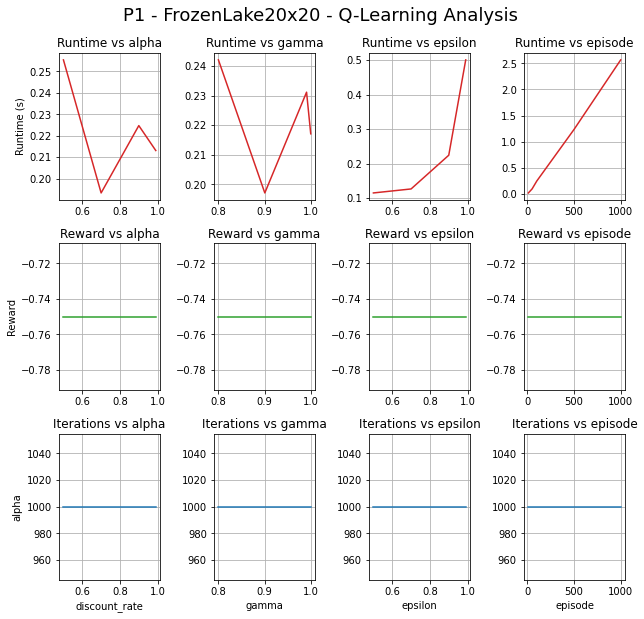

In [79]:
alpha = [0.5, 0.7, 0.9, 0.99]
gamma = [0.8, 0.9, 0.99, 0.999 ]
eps = [0.5, 0.7, 0.9, 0.99]
episode = [10, 50, 100, 500, 1000]

fig, axs = plt.subplots(3,4, figsize=(9,9))
axs[0, 0].plot(alpha, alpha_var[:,0], 'tab:red')
axs[0, 0].set_title('Runtime vs alpha')
axs[0, 0].set(ylabel='Runtime (s)')
axs[0, 0].grid()
axs[0, 1].plot(gamma, gamma_var[:,0], 'tab:red')
axs[0, 1].set_title('Runtime vs gamma')
axs[0, 1].grid()
axs[0, 2].plot(eps, epsilon_var[:,0], 'tab:red')
axs[0, 2].set_title('Runtime vs epsilon')
axs[0, 2].grid()
axs[0, 3].plot(episode, episode_var[:,0], 'tab:red')
axs[0, 3].set_title('Runtime vs episode')
axs[0, 3].grid()

axs[1, 0].plot(alpha, alpha_var[:,1], 'tab:green')
axs[1, 0].set_title('Reward vs alpha')
axs[1, 0].set(ylabel='Reward')
axs[1, 0].grid()
axs[1, 1].plot(gamma, gamma_var[:,1], 'tab:green')
axs[1, 1].set_title('Reward vs gamma')
axs[1, 1].grid()
axs[1, 2].plot(eps, epsilon_var[:,1], 'tab:green')
axs[1, 2].set_title('Reward vs epsilon')
axs[1, 2].grid()
axs[1, 3].plot(episode, episode_var[:,1], 'tab:green' )
axs[1, 3].set_title('Reward vs episode')
axs[1, 3].grid()

axs[2, 0].plot(alpha, alpha_var[:,2], 'tab:blue')
axs[2, 0].set_title('Iterations vs alpha')
axs[2, 0].set(xlabel='discount_rate')
axs[2, 0].set(ylabel='Iterations')
axs[2, 0].grid()
axs[2, 1].plot(gamma, gamma_var[:,2], 'tab:blue')
axs[2, 1].set_title('Iterations vs gamma')
axs[2, 1].set(xlabel='gamma')
axs[2, 1].grid()
axs[2, 2].plot(eps, epsilon_var[:,2], 'tab:blue')
axs[2, 2].set_title('Iterations vs epsilon')
axs[2, 2].set(xlabel='epsilon')
axs[2, 2].grid()
axs[2, 3].plot(episode, episode_var[:,2], 'tab:blue')
axs[2, 3].set_title('Iterations vs episode')
axs[2, 3].set(xlabel='episode')
axs[2, 3].grid()


fig.suptitle('P1 - FrozenLake20x20 - Q-Learning Analysis', fontsize=18)

#plt.legend()
#plt.ylim(0, 5e-6)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [82]:
print (episode_var[:,2])
print (best_policy)

[1000. 1000. 1000. 1000. 1000.]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 2, 1, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0

In [65]:
# plot policy
def plot_policy(size, policy):
    name = str(size)+'x'+str(size)
    #discrete_map = np.array([[-1,-1,-1,-1],[-1, 0, -1, 0],[-1,-1,-1, 0],[0, -1,-1, 1]])
    aaa=[MAPS["20x20"]]
    dis_map = np.zeros((20,20))
    for i, row in enumerate(aaa[0]):
        print (i,row)
        for j, loc in enumerate(row):
            if loc == "S":
                dis_map[i, j] = -1
            elif loc == "F":
                dis_map[i, j] = -1
            elif loc == "H":
                dis_map[i, j] = 0
            elif loc == "G":
                dis_map[i, j] = 1

    plt.figure(figsize = (10,10))
    plt.imshow(dis_map, cmap='brg')
    
    policy_reshape = policy.reshape((size, size))
    
    for i in range(size):
        for j in range(size):
            if policy_reshape[i][j]==0:
                arrow = '\u2190'
            elif policy_reshape[i][j]==1:
                arrow = '\u2193'
            elif policy_reshape[i][j]== 2:
                arrow = '\u2192'
            else:
                arrow = '\u2191'
            plotText = plt.text(j, i, arrow, ha="center", va="center", color="w", size=15)    
    plt.title('FrozenLake 20x20 Best Policy ')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()

0 SFFHFFFHFHFFHFFHFFFF
1 FFFFFFFFFFFFFHHHFFFF
2 FFHFHHHFFFFFFFHFFFFF
3 HFFFFFFFHFFFFFFFFFFH
4 FFFFFFFFFHFFFFFFFFHF
5 FFFFHFFFFHFFFFHFFHHF
6 FFFFFFFFFFFFFFFFFFHF
7 FFFFFFFFFFHFHFFFFFHF
8 FFFFFHHFFFFFFFFHFFFH
9 FFFFFFFFHFFFHFFFFFFH
10 HFFFFFFFHHHFFFFFFFHF
11 FFFFHHFFHFFFFFFHFFFF
12 FFFFHFHFHFFFFFFFFFFF
13 FFHHFFFFFFFHFFFFFFHF
14 FFFFHHFHFFHFFFFHFFFF
15 FHFHFHFFFFFHHFFFHFFF
16 FFHFFFFHHFFHHFFFFFFF
17 FHFHFFFFHFFFFFFFFFFF
18 HFFFFFFFFHFFFFFHHFFF
19 FFFFFFFFHFFHFFFFFHHG


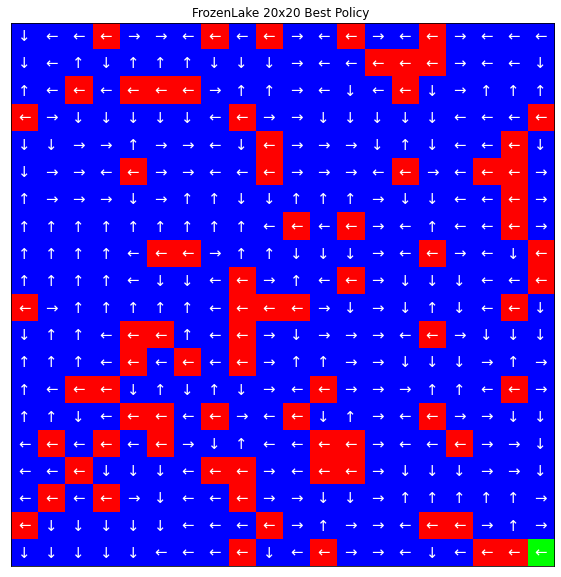

0 SFFHFFFHFHFFHFFHFFFF
1 FFFFFFFFFFFFFHHHFFFF
2 FFHFHHHFFFFFFFHFFFFF
3 HFFFFFFFHFFFFFFFFFFH
4 FFFFFFFFFHFFFFFFFFHF
5 FFFFHFFFFHFFFFHFFHHF
6 FFFFFFFFFFFFFFFFFFHF
7 FFFFFFFFFFHFHFFFFFHF
8 FFFFFHHFFFFFFFFHFFFH
9 FFFFFFFFHFFFHFFFFFFH
10 HFFFFFFFHHHFFFFFFFHF
11 FFFFHHFFHFFFFFFHFFFF
12 FFFFHFHFHFFFFFFFFFFF
13 FFHHFFFFFFFHFFFFFFHF
14 FFFFHHFHFFHFFFFHFFFF
15 FHFHFHFFFFFHHFFFHFFF
16 FFHFFFFHHFFHHFFFFFFF
17 FHFHFFFFHFFFFFFFFFFF
18 HFFFFFFFFHFFFFFHHFFF
19 FFFFFFFFHFFHFFFFFHHG


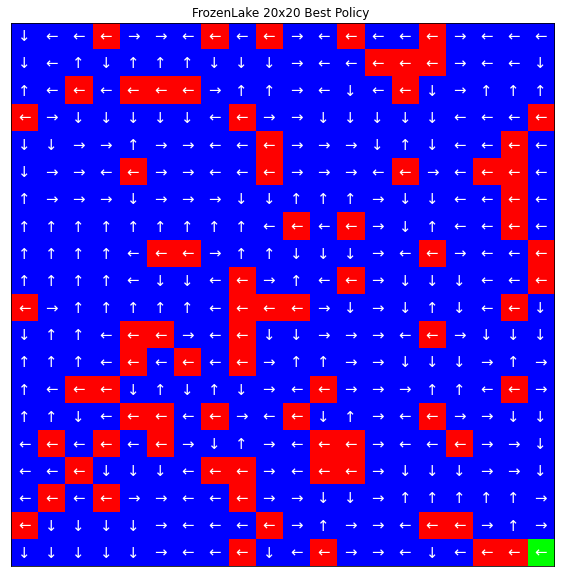

NameError: name 'env1' is not defined

In [66]:
vi_iter_val, vi_policy_val, vi_time_val = vi(env, 0.999, 1e-5)
plot_policy(20, vi_policy_val)
pi_iter_val, pi_policy_val, pi_time_val = pi2(env, 0.999, 1e-11)
plot_policy(20, pi_policy_val)
best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env1, alpha=0.9, gamma=0.99, eps=0.9, episodes = 100)
plot_policy(20, np.array(best_policy))

0 SFFHFFFHFHFFHFFHFFFF
1 FFFFFFFFFFFFFHHHFFFF
2 FFHFHHHFFFFFFFHFFFFF
3 HFFFFFFFHFFFFFFFFFFH
4 FFFFFFFFFHFFFFFFFFHF
5 FFFFHFFFFHFFFFHFFHHF
6 FFFFFFFFFFFFFFFFFFHF
7 FFFFFFFFFFHFHFFFFFHF
8 FFFFFHHFFFFFFFFHFFFH
9 FFFFFFFFHFFFHFFFFFFH
10 HFFFFFFFHHHFFFFFFFHF
11 FFFFHHFFHFFFFFFHFFFF
12 FFFFHFHFHFFFFFFFFFFF
13 FFHHFFFFFFFHFFFFFFHF
14 FFFFHHFHFFHFFFFHFFFF
15 FHFHFHFFFFFHHFFFHFFF
16 FFHFFFFHHFFHHFFFFFFF
17 FHFHFFFFHFFFFFFFFFFF
18 HFFFFFFFFHFFFFFHHFFF
19 FFFFFFFFHFFHFFFFFHHG


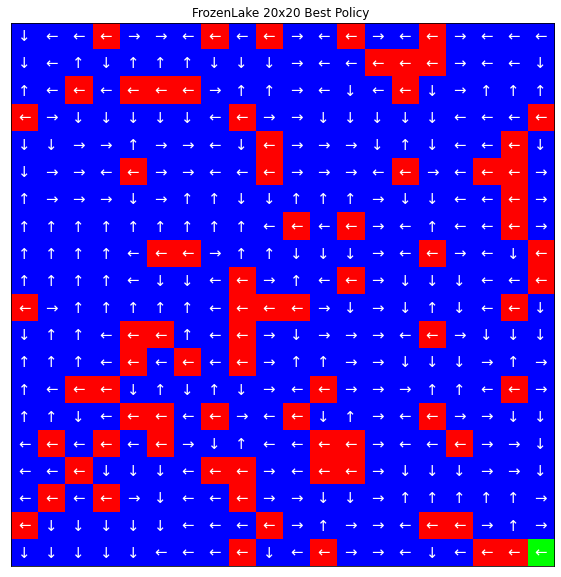

In [68]:
vi_iter_val, vi_policy_val, vi_time_val = vi(env, 0.999, 1e-5)
plot_policy(20, vi_policy_val)

0 SFFHFFFHFHFFHFFHFFFF
1 FFFFFFFFFFFFFHHHFFFF
2 FFHFHHHFFFFFFFHFFFFF
3 HFFFFFFFHFFFFFFFFFFH
4 FFFFFFFFFHFFFFFFFFHF
5 FFFFHFFFFHFFFFHFFHHF
6 FFFFFFFFFFFFFFFFFFHF
7 FFFFFFFFFFHFHFFFFFHF
8 FFFFFHHFFFFFFFFHFFFH
9 FFFFFFFFHFFFHFFFFFFH
10 HFFFFFFFHHHFFFFFFFHF
11 FFFFHHFFHFFFFFFHFFFF
12 FFFFHFHFHFFFFFFFFFFF
13 FFHHFFFFFFFHFFFFFFHF
14 FFFFHHFHFFHFFFFHFFFF
15 FHFHFHFFFFFHHFFFHFFF
16 FFHFFFFHHFFHHFFFFFFF
17 FHFHFFFFHFFFFFFFFFFF
18 HFFFFFFFFHFFFFFHHFFF
19 FFFFFFFFHFFHFFFFFHHG


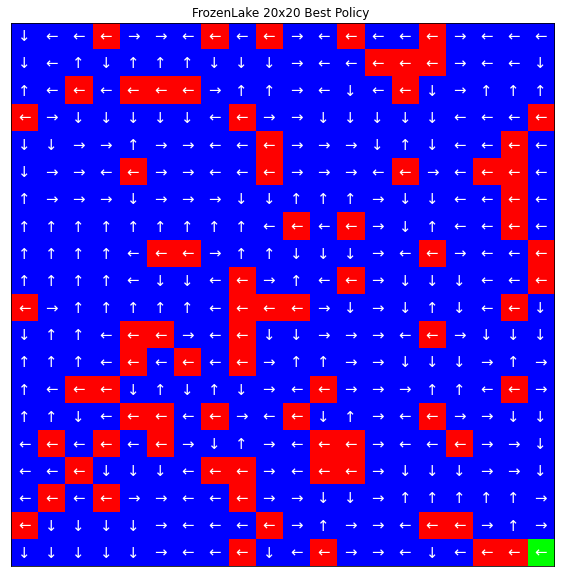

In [69]:
pi_iter_val, pi_policy_val, pi_time_val = pi2(env, 0.999, 1e-11)
plot_policy(20, pi_policy_val)

0 SFFHFFFHFHFFHFFHFFFF
1 FFFFFFFFFFFFFHHHFFFF
2 FFHFHHHFFFFFFFHFFFFF
3 HFFFFFFFHFFFFFFFFFFH
4 FFFFFFFFFHFFFFFFFFHF
5 FFFFHFFFFHFFFFHFFHHF
6 FFFFFFFFFFFFFFFFFFHF
7 FFFFFFFFFFHFHFFFFFHF
8 FFFFFHHFFFFFFFFHFFFH
9 FFFFFFFFHFFFHFFFFFFH
10 HFFFFFFFHHHFFFFFFFHF
11 FFFFHHFFHFFFFFFHFFFF
12 FFFFHFHFHFFFFFFFFFFF
13 FFHHFFFFFFFHFFFFFFHF
14 FFFFHHFHFFHFFFFHFFFF
15 FHFHFHFFFFFHHFFFHFFF
16 FFHFFFFHHFFHHFFFFFFF
17 FHFHFFFFHFFFFFFFFFFF
18 HFFFFFFFFHFFFFFHHFFF
19 FFFFFFFFHFFHFFFFFHHG


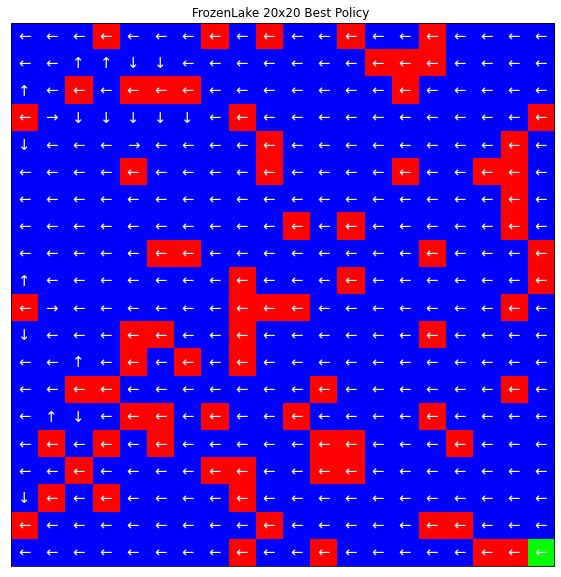

In [67]:
best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env, alpha=0.9, gamma=0.99, eps=0.9, episodes = 100)
plot_policy(20, np.array(best_policy))

In [72]:
best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env, alpha=0.9, gamma=0.99, eps=0.9, episodes = 100000)

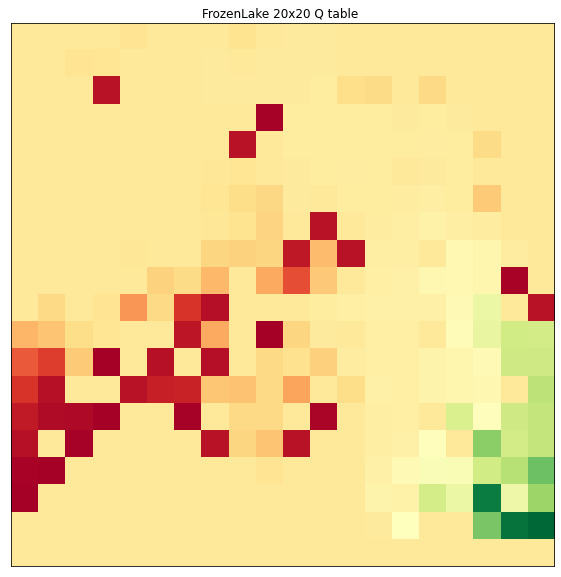

In [76]:
aaa = np.max(Q, 1).reshape((20,20))
plt.figure(figsize = (10,10))
plt.imshow(aaa,  cmap='RdYlGn')
plt.title('FrozenLake 20x20 Q table ')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)